**Import Dataset**\
Download dataset: https://www.kaggle.com/gti-upm/leapgestrecog
\
\
The folder "leapGestRecog" has 10 subfolders, and these datasets are sampled from 10 different people. Each subfolder contains 10 subfolders for different gestures.


**Install Tensorflow 2.0**

In [0]:
!pip install tensorflow==2.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Library**

In [0]:
# General
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import time 
from matplotlib import pyplot as plt

# Keras
from keras.utils import to_categorical
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [0]:
print(tf.__version__)

2.0.0


**Exploratory Data Analysis**

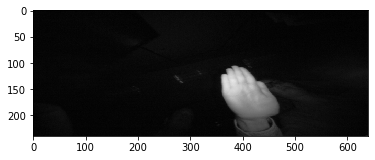

In [0]:
img = cv2.imread("/content/drive/My Drive/leapGestRecog/00/01_palm/frame_00_01_0001.png")
plt.imshow(img)
plt.show()

In [0]:
# Check image size
img.shape

(240, 640, 3)

In [0]:
img = cv2.resize(img,(160,80))
img.shape

(80, 160, 3)

image resize width hight is reverse to numpy array!!!

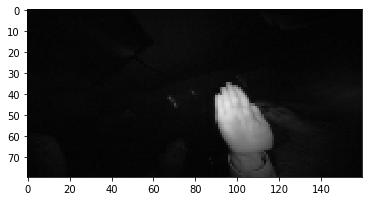

In [0]:
plt.imshow(img)
plt.show()

In [0]:
# Convert to Gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img.shape

(80, 160)

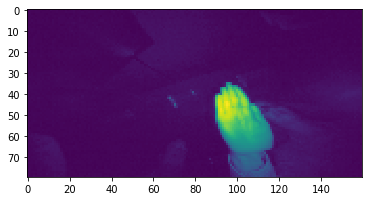

In [0]:
plt.imshow(img)
plt.show()

**Boundary Box**

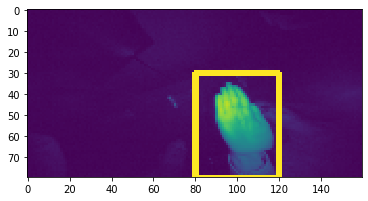

In [0]:
# Copy image
img_copy = img.copy()

# Draw a rectangle
# cv2.rectangle(image, top_left_corner, bottom_right_corner, color, thickness ) 
img_rec = cv2.rectangle(img_copy, (80, 30), (120, 80), (255, 0, 0), 2) 
  
# Image Show 
plt.imshow(img_rec)
plt.show()

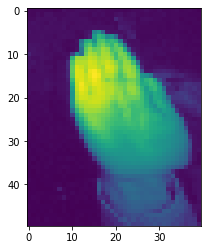

In [0]:
# Copy image
img_copy = img.copy()

# Capture hand (y_start:y_end,x_start:x_end)
img_hand = img_copy[30:80,80:120]
plt.imshow(img_hand)
plt.show()

**Data Labeling**

In [0]:
def labeling(input_path):
  """
  This function is used for listing down the image filename and its label in csv file
  input_path:   The directory where image files are saved.
  filename:     A list includes all filenames.
  label:        A list includes directory names as labeling 
  """
  # Walk through all directory and files. 
  # List down all files which have "png" extension
  filename_list = []
  label = []
  for root, dirs, file in os.walk(input_path):
    for filename in file:
      if filename.endswith("png"):
        filename_list.append(filename)
        label.append(os.path.basename(root))
  # Save filename and label in a csv file
  df = pd.DataFrame(list(zip(filename_list, label)), columns =['filename', 'label'])
  translate = {'01_palm': 0, 
               '02_l': 1, 
               '03_fist': 2, 
               '04_fist_moved': 3, 
               '05_thumb': 4, 
               '06_index': 5, 
               '07_ok': 6, 
               '08_palm_moved': 7,
               '09_c': 8, 
               '10_down': 9}
  df['label'].replace(translate, inplace=True)
  df.to_csv('label.csv', index=False)               
  return filename_list, label

In [0]:
input_path = '/content/drive/My Drive/leapGestRecog'
filename_list, _ =labeling(input_path)

In [0]:
print('total image files: ', len(filename_list))

total image files:  20000


In [0]:
df = pd.read_csv('label.csv')
df

,filename,label
0,frame_00_01_0001.png,0
1,frame_00_01_0002.png,0
2,frame_00_01_0008.png,0
3,frame_00_01_0003.png,0
4,frame_00_01_0007.png,0
...,...,...
19995,frame_09_10_0188.png,9
19996,frame_09_10_0197.png,9
19997,frame_09_10_0198.png,9
19998,frame_09_10_0199.png,9


**Create new images (reszie, convert to gray scale,...etc)**

In [0]:
def create_img(input_path,size):
  """
  This function is used for image processing 
  input_path: the directory where image files are saved.
  size:   new image size
  """
  # Create a new folder to save new images
  outpath = input_path + '_new'
  # Delete folder if it exists
  current_path = os.getcwd()
  if os.path.exists(outpath):
    shutil.rmtree(outpath)
  os.mkdir(outpath)
  os.chdir(outpath)
  # Walk through all directory and files
  image_list = []
  for root, dirs, file in os.walk(input_path):
    for filename in file:
      if filename.endswith("png"):
        image_list.append(filename)
        path = os.path.join(root,filename)
        # Image processing
        img = cv2.imread(path)
        # Convert to gray scale
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize image 
        img_new = cv2.resize(img_new, size)
        # Save image
        cv2.imwrite(filename,img_new)
  os.chdir(current_path)
  return image_list

In [0]:
# Create new images
while True:
  x = input("Create new images?[y/n]: ")
  if x == 'y':
    input_path = '/content/drive/My Drive/leapGestRecog'
    img_list = create_img(input_path,size=(80,60))
    print("total image files: ", len(img_list))
    break
  elif x == 'n':
    break

Create new images?[y/n]: n


**Now, we need to save all images into a numpy array**

In [0]:
def process_data(inpath,size):
  """
  Input:
  inpath      the directory where image files are saved.
  size        image width, image height
  Outpt:
  x_data      image   dtype: numpy array
  y_data      label   dtype: numpy array
  """
  x_data = []
  y_data = []
  for i in os.listdir(inpath):
    filename = os.path.join(inpath,i)
    img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE )      
    # Covnert x_data to a list
    arr = np.array(img)
    x_data.append(arr)
    # Covnert y_data to a list 
    df_temp = df.loc[df.filename == i]
    y_data.append(df_temp.iloc[0]['label']) 

  # Convert lists to numpy array  
  x_data = np.array(x_data, dtype = 'float32')
  y_data = np.array(y_data)
  # Reshape 
  x_data = x_data.reshape((len(x_data), size[1], size[0], 1))
  y_data = y_data.reshape(len(x_data), 1)
  # Normalization
  x_data /= 255

  return x_data, y_data

In [0]:
inpath = '/content/drive/My Drive/leapGestRecog_new'
size = (80,60)
x_data, y_data = process_data(inpath,size)

In [0]:
x_data.shape

(20000, 60, 80, 1)

In [0]:
y_data.shape

(20000, 1)

**Split dataset to training and testing dataset**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [0]:
X_train.shape

(14000, 60, 80, 1)

In [0]:
y_train.shape

(14000, 1)

In [0]:
X_test.shape

(6000, 60, 80, 1)

In [0]:
y_test.shape

(6000, 1)

In [0]:
# In order to save training time, we just take 2000 samples as training and 1600 samples as testing
#X_train = X_train[:2000,:,:,:]
#y_train = y_train[:2000,:]
#X_test = X_test[:1600,:,:,:]
#y_test = y_test[:1600,:]

**Create Models**

In [0]:
def model_1(size):
  """
  Keras
  size:     input shape. For example: (224,224,1)
  """
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=size)) 
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
def model_2(size):
  """
  Tensorflow
  size:     input shape. For example: (224,224,1)
  """
  classes=10
  model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=size),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(classes, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

**Data Augmentation**

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

**Model Training**

In [0]:
# Load model
# model = tf.keras.models.load_model('my_model.h5')
# model.summary()

In [0]:
# Create two models, w/i and w/o data augmentation
size = (60,80,1)
model = model_2(size)
model_aug  = model_2(size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 78, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14976)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1917056   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [0]:
# Model Training (w/o data augmentation)
start = time.time()
model.fit(X_train, y_train, batch_size=64,epochs=5,validation_data=(X_test, y_test))
end = time.time()
diff=end-start
print('total time:{}sec:'.format(diff))

Train on 14000 samples, validate on 6000 samples
Epoch 1/5
14000/14000 [==============================] - 96s 7ms/sample - loss: 0.3502 - accuracy: 0.8965 - val_loss: 0.0178 - val_accuracy: 0.9970
Epoch 2/5
14000/14000 [==============================] - 96s 7ms/sample - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.0173 - val_accuracy: 0.9967
Epoch 3/5
14000/14000 [==============================] - 96s 7ms/sample - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0064 - val_accuracy: 0.9983
Epoch 4/5
14000/14000 [==============================] - 97s 7ms/sample - loss: 4.1222e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9993
Epoch 5/5
14000/14000 [==============================] - 97s 7ms/sample - loss: 1.4640e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9992
total time:481.7274167537689sec:


In [0]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
# Model Training (w/i data augmentation)
start = time.time()
model_aug.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=20,
                    validation_data=(X_test, y_test))
end = time.time()
diff=end-start
print('total time:{}sec:'.format(diff))

Epoch 1/20
219/219 [==============================] - 126s 576ms/step - loss: 1.4384 - accuracy: 0.4942 - val_loss: 1.5660 - val_accuracy: 0.6148
Epoch 2/20
219/219 [==============================] - 125s 570ms/step - loss: 0.5726 - accuracy: 0.8072 - val_loss: 1.3465 - val_accuracy: 0.6690
Epoch 3/20
219/219 [==============================] - 125s 572ms/step - loss: 0.3255 - accuracy: 0.8961 - val_loss: 1.2158 - val_accuracy: 0.6842
Epoch 4/20
219/219 [==============================] - 124s 567ms/step - loss: 0.2332 - accuracy: 0.9253 - val_loss: 1.2692 - val_accuracy: 0.6500
Epoch 5/20
219/219 [==============================] - 124s 567ms/step - loss: 0.1740 - accuracy: 0.9479 - val_loss: 1.5485 - val_accuracy: 0.4603
Epoch 6/20
219/219 [==============================] - 125s 569ms/step - loss: 0.1383 - accuracy: 0.9583 - val_loss: 1.7796 - val_accuracy: 0.3508
Epoch 7/20
219/219 [==============================] - 124s 568ms/step - loss: 0.1224 - accuracy: 0.9623 - val_loss: 1.8809 -

In [0]:
[loss, acc] = model_aug.evaluate(X_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Model Evaluation**

In [0]:
y_pred= model.predict(X_test)
y_pred

array([[2.27098678e-12, 7.49961898e-11, 1.12854877e-05, ...,
        1.24371238e-12, 2.37466566e-07, 8.62069693e-13],
       [1.00000000e+00, 4.55491513e-11, 1.22821964e-09, ...,
        7.54401292e-18, 2.31156541e-15, 2.87506441e-17],
       [3.59937076e-06, 1.84347101e-07, 2.67815398e-04, ...,
        1.79420590e-06, 2.53806011e-05, 1.15033147e-08],
       ...,
       [8.78106277e-07, 2.50293215e-05, 5.60020169e-07, ...,
        5.48789382e-11, 5.97106132e-13, 2.12500208e-06],
       [6.42664866e-10, 2.79723871e-08, 9.99999881e-01, ...,
        2.28023080e-21, 3.52521380e-11, 1.15667021e-16],
       [4.62644090e-11, 1.08342554e-07, 7.09934111e-09, ...,
        2.35091499e-23, 3.16041355e-12, 1.31850509e-19]], dtype=float32)

In [0]:
y_pred = model.predict_classes(X_test)
y_pred

array([3, 0, 3, ..., 5, 2, 5])

In [0]:
# Confustion Matrix: row(y_true), column(y_pred)
# L: label, C: column, I: index
L = [0,1,2,3,4,5,6,7,8,9]
C = ['pred_palm','pred_l','pred_fist','pred_fist_moved','pred_thumb','pred_index','pred_ok','pred_palm_moved','pred_c','pred_down']
I = ['act_palm','act_l','act_fist','act_fist_moved','act_thumb','act_index','act_ok','act_palm_moved','act_c','act_down']
pd.DataFrame(confusion_matrix(y_test, y_pred,labels=L), columns=C,index=I)

,pred_palm,pred_l,pred_fist,pred_fist_moved,pred_thumb,pred_index,pred_ok,pred_palm_moved,pred_c,pred_down
act_palm,603,2,0,0,0,0,0,0,0,0
act_l,0,600,0,0,0,0,0,0,0,0
act_fist,2,0,609,0,0,0,0,0,0,0
act_fist_moved,0,0,0,582,0,0,0,0,0,0
act_thumb,0,0,1,0,576,0,0,0,0,0
act_index,0,0,0,0,0,596,0,0,0,0
act_ok,0,0,0,0,0,0,587,0,0,0
act_palm_moved,0,0,0,0,0,0,0,589,0,0
act_c,0,0,0,0,0,0,0,0,654,0
act_down,0,0,0,0,0,0,0,0,0,599


In [0]:
# Precision:  TP/(TP+FP)
# Recall:     TP/(TP+FN)
# F1-score:   2*(Precision*Recall)/(Precision+Recall)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       611
           3       1.00      1.00      1.00       582
           4       1.00      1.00      1.00       577
           5       1.00      1.00      1.00       596
           6       1.00      1.00      1.00       587
           7       1.00      1.00      1.00       589
           8       1.00      1.00      1.00       654
           9       1.00      1.00      1.00       599

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



**Save Model**

In [0]:
# model save
model.save('my_model.h5')

**Reference:**
* https://towardsdatascience.com/training-a-neural-network-to-detect-gestures-with-opencv-in-python-e09b0a12bdf1
* https://colab.research.google.com/github/filipefborba/HandRecognition/blob/master/project3/project3.ipynb
* https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/tf_handBbox_esitmation.ipynb